# Match UNIONS and HSC PSF stars

References:
- Li et al. (2022), HSC-SSP Y3 shear catalogue
  https://arxiv.org/abs/2107.00136
- Aihara et al. (2021), HSC-SSP Y3 data release
  https://arxiv.org/abs/2108.13045

In [1]:
import os

import astropy.coordinates as coords
from astropy.io import fits
from astropy import units

from uncertainties import ufloat
import pandas as pd

import matplotlib.colors as colors

from sp_validation.plots import *

In [2]:
# Tolerance: Set in ShapePipe config file of the match_external module.
# Largest distance to define matched pair

tol = 0.5   # in arcsec

In [4]:
# Open matched catalogue
hdu_list = fits.open('output/run_sp_match_ext/match_external_runner/output/cat_matched-0000000.fits')

In [5]:
data = hdu_list[1].data

In [6]:
data.dtype.names

('X',
 'Y',
 'RA',
 'DEC',
 'E1_PSF_HSM',
 'E2_PSF_HSM',
 'SIGMA_PSF_HSM',
 'E1_STAR_HSM',
 'E2_STAR_HSM',
 'SIGMA_STAR_HSM',
 'FLAG_PSF_HSM',
 'FLAG_STAR_HSM',
 'CCD_NB',
 'ira',
 'idec',
 'imag_psf',
 'imag_psf_err',
 'object_id',
 'distance')

In [7]:
len(data)

167611

In [8]:
# Use only objects with valid PSF flag
m_flag = (data['FLAG_STAR_HSM'] == 0)
len(np.where(m_flag)[0])

167573

In [10]:
# Mask out objects with invalid coordinates (due to previous MCCD bug)
m_coord = (
    (data['RA'] != 0)
    & (data['DEC'] != 0)
)
len(np.where(m_coord)[0])

167439

In [13]:
# Remove unmatched objects which have been marked by -99
# (see ShapePipe config file)
m_match = data['ira'] != -99
len(np.where(m_match)[0])

16481

In [15]:
m_val = m_flag & m_match

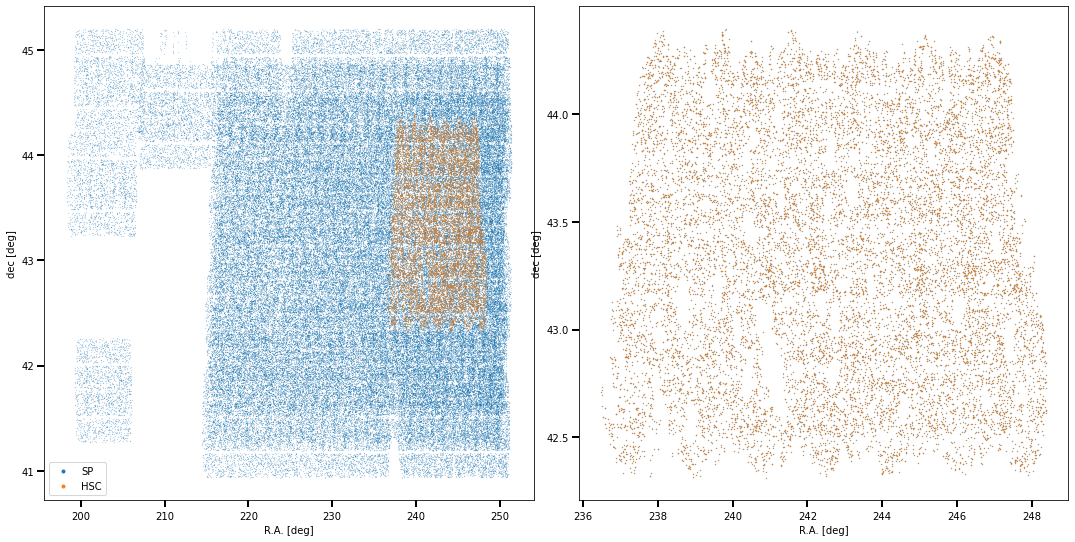

In [16]:
# Plot spatial distribution
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 7.5))
plt.tight_layout()

ms = [0.2, 0.5]

axes[0].plot(data['RA'][m_coord], data['DEC'][m_coord], '.', markersize=ms[0], label='SP')
axes[1].plot(data['RA'][m_val], data['DEC'][m_val], '.', markersize=ms[1])

for idx, ax in enumerate(axes):
    ax.plot(data['ira'][m_val], data['idec'][m_val], '.', markersize=ms[idx], label='HSC')


axes[0].legend(markerscale=30)

for ax in axes:
    ax.set_xlabel('R.A. [deg]')
    ax.set_ylabel('dec [deg]')

In [162]:
print(data['distance'].max(), data['distance'][m_val].max())

380420.40329404024 0.49996702246051966


In [163]:
len(np.where(data['distance'] < tol)[0])

16481

In [164]:
title = 'UNIONS-r HSC PSF stars'
n_bin = 200

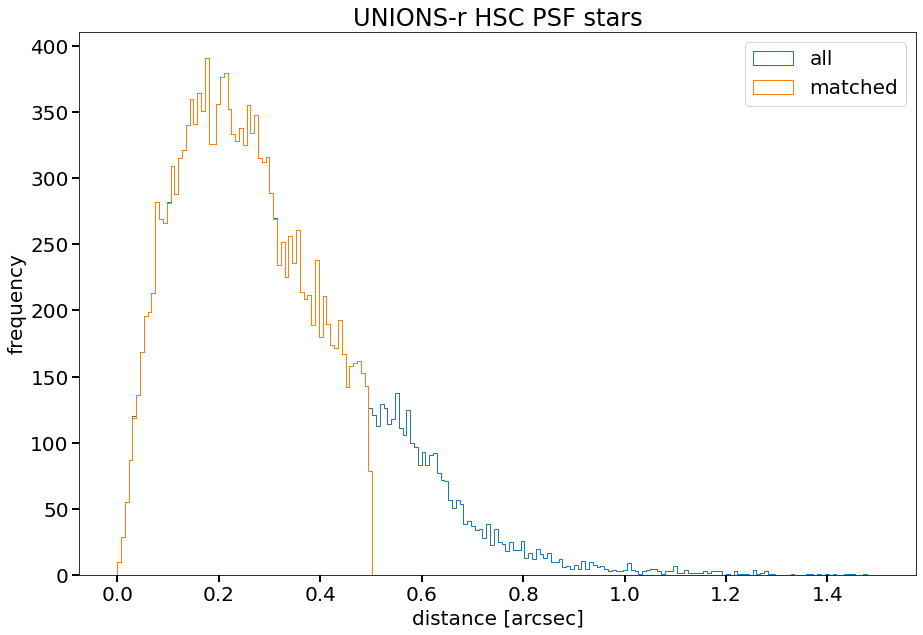

In [165]:
plot_histograms(
    [data['distance'], data['distance'][m_val]],
    ['all', 'matched'],
    title,
    'distance [arcsec]',
    'frequency',
    [0, 1.5],
    n_bin,
    'hist_dist',
    density=False
)

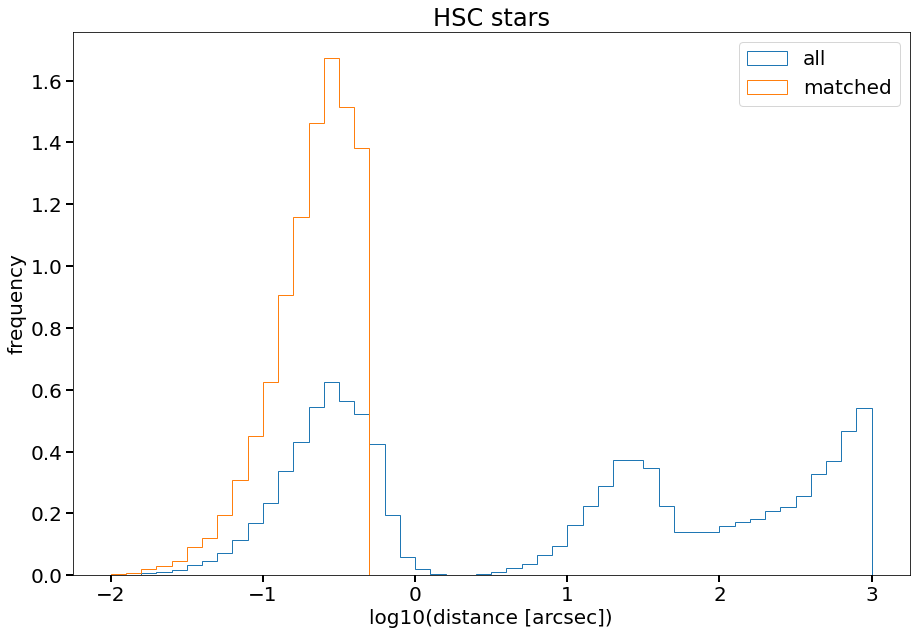

In [202]:
n_bin = 50
plot_histograms(
    [np.log10(data['distance']), np.log10(data['distance'][m_val])],
    ['all', 'matched'],
    title,
    'log10(distance [arcsec])',
    'frequency',
    [-2, 3],
    n_bin,
    'log_hist_dist'
)

In [203]:
# Upper limiting distance to define potential match,
tol_up = 3 # in arcsec

In [204]:
m_unmatched = (
    (data['distance'] > tol)
    & (data['distance'] < tol_up)
    & m_flag
)

In [205]:
print(len(data['RA'][m_unmatched]), len(data['RA'][m_val]))

3171 16478


Text(0, 0.5, 'dec [deg]')

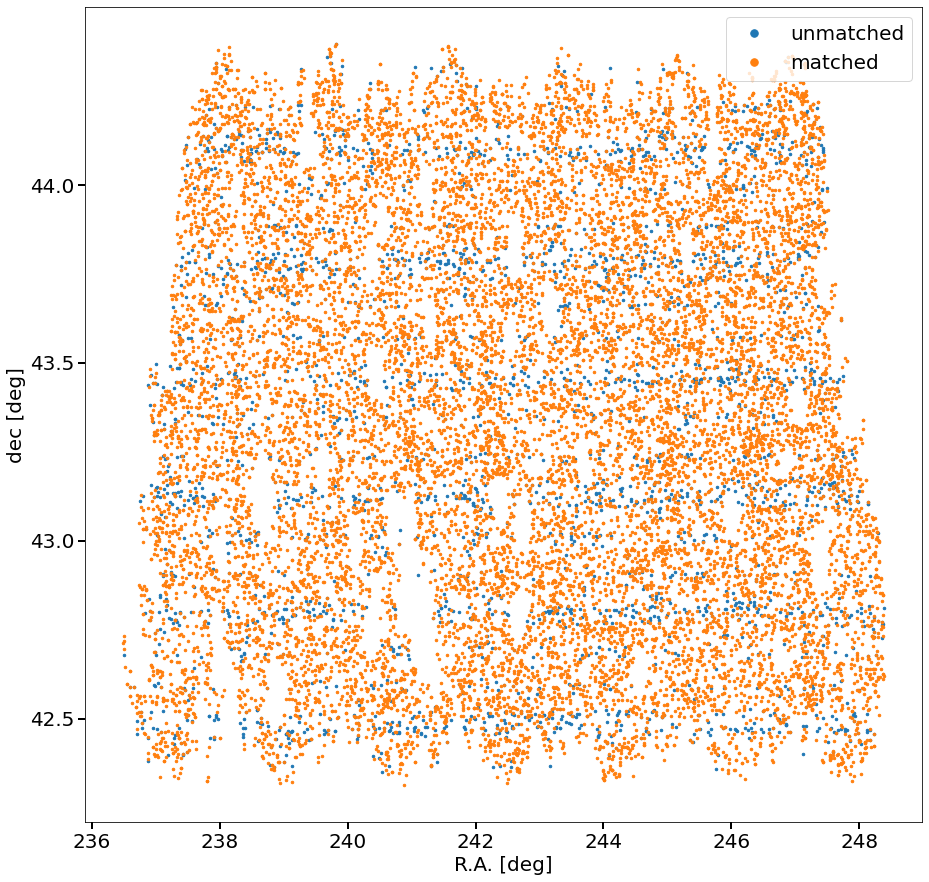

In [213]:
# Plot spatial distribution
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 15))

ms = 5

ax.plot(data['RA'][m_unmatched], data['DEC'][m_unmatched], '.', markersize=ms, label='unmatched')
ax.plot(data['ira'][m_val], data['idec'][m_val], '.', markersize=ms, label='matched')

ax.legend(markerscale=3)

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('dec [deg]')

In [20]:
# Open original HSC star catalogue
hdu_list_hsc = fits.open('/n17data/mkilbing/astro/data/CFIS/imaging_surveys/HECTOMAP_stars.fits')

In [21]:
data_hsc = hdu_list_hsc[1].data

In [23]:
data_hsc.dtype.names

('object_id',
 'parent_id',
 'ira',
 'idec',
 'imag_psf',
 'imag_psf_err',
 'iflux_psf',
 'iflux_psf_err',
 'iflux_psf_flags',
 'ishape_sdss_ixx',
 'ishape_sdss_iyy',
 'ishape_sdss_ixy',
 'ishape_sdss_ixx_var',
 'ishape_sdss_iyy_var',
 'ishape_sdss_ixy_var',
 'ishape_sdss_psf_ixx',
 'ishape_sdss_psf_iyy',
 'ishape_sdss_psf_ixy',
 'tract',
 'icalib_psf_used',
 'merge_peak_g',
 'merge_peak_r',
 'merge_peak_i',
 'merge_peak_z',
 'merge_peak_y',
 'icountinputs',
 'ideblend_has_stray_flux',
 'iflags_pixel_bright_object_center',
 'iflags_pixel_bright_object_any',
 'iblendedness_abs_flux',
 'iflags_negative',
 'ideblend_too_many_peaks',
 'ideblend_parent_too_big',
 'icentroid_naive_flags',
 'iflags_pixel_interpolated_any',
 'iflags_pixel_saturated_any',
 'iflags_pixel_cr_any',
 'iflags_pixel_suspect_any',
 'brightStarMask_isOutside')

In [29]:
ra_min = data['RA'][m_val].min()
ra_max = data['RA'][m_val].max()
dec_min = data['DEC'][m_val].min()
dec_max = data['DEC'][m_val].max()

print('UNIONS coordinate limits')
print(ra_min, ra_max, dec_min, dec_max)


ira_min = data_hsc['ira'].min()
ira_max = data_hsc['ira'].max()
idec_min = data_hsc['idec'].min()
idec_max = data_hsc['idec'].max()

print('HSC coordinate limits')
print(ira_min, ira_max, idec_min, idec_max)

# Mask HSC stars in area of UNIONS - HSC match (rough estimate)
m_area = (
    (data_hsc['ira'] > ra_min)
    & (data_hsc['ira'] < ra_max)
    & (data_hsc['idec'] > dec_min)
    & (data_hsc['idec'] < dec_max)
)

UNIONS coordinate limits
236.4892404300041 248.382203281428 42.31263395932906 44.395516500710734
HSC coordinate limits
236.46644367314383 248.40459825197968 42.31263032764033 44.39554894167647


In [33]:
print(len(data_hsc['ira']), len(data_hsc['ira'][m_area]))

85734 85714


Text(0, 0.5, 'dec [deg]')

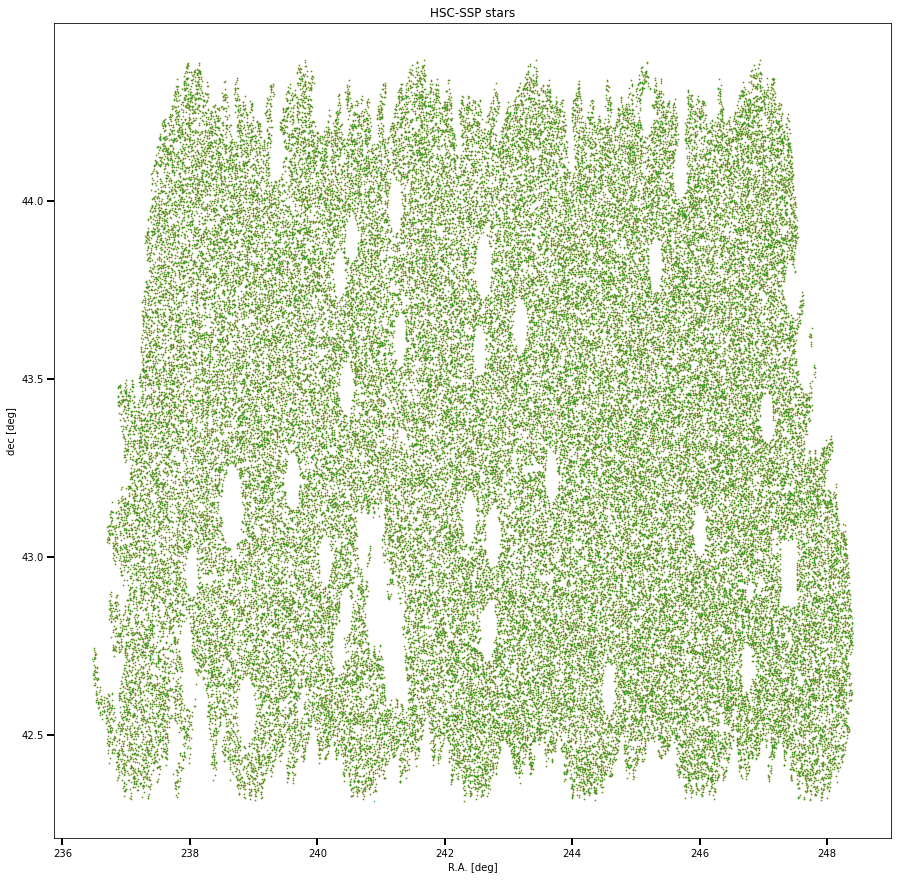

In [31]:
# Plot spatial distribution
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 15))

ms = 1

prop_cycle = plt.rcParams['axes.prop_cycle']                            
colors = prop_cycle.by_key()['color']    

ax.plot(data_hsc['ira'][m_area], data_hsc['idec'][m_area], '.', markersize=ms, color=colors[1])
ax.plot(data_hsc['ira'], data_hsc['idec'], '.', markersize=ms, color=colors[2])


ax.set_title('HSC-SSP stars')
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('dec [deg]')

In [183]:
ids_matched = data['object_id'][m_val]

In [189]:
m_ids_matched = np.in1d(data_hsc['object_id'], data['object_id'][m_val])

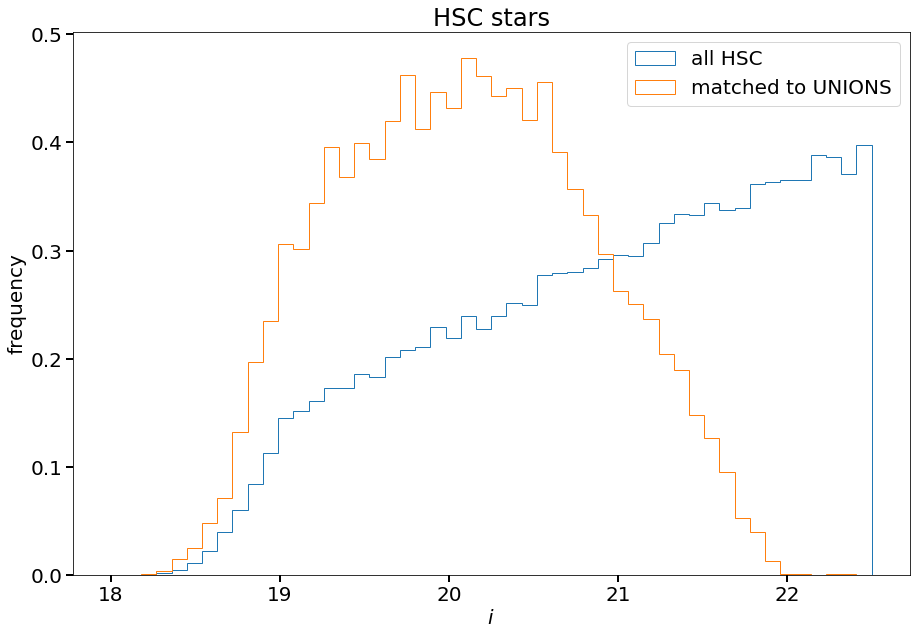

In [214]:
n_bin = 50
title = 'HSC stars'
plot_histograms(
    [data_hsc['imag_psf'][m_area], data_hsc['imag_psf'][m_ids_matched]],
    ['all HSC', 'matched to UNIONS'],
    title,
    '$i$',
    'frequency',
    [18, 22.5],
    n_bin,
    'mag_i_hsc',
    density=True
)